In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, shutil
ROOT_PROJECT =  os.path.join(os.path.normpath(os.path.join(os.getcwd(), "../")))
sys.path[0] = ROOT_PROJECT

import numpy as np
import os, glob

import matplotlib
from matplotlib import colors, colorbar
from matplotlib import cm
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats, clear_output

import matplotlib_inline.backend_inline
ipython_format = "retina"
if isinstance(ipython_format, str):
    ipython_format = [ipython_format]
matplotlib_inline.backend_inline.set_matplotlib_formats(*ipython_format)

# plt.style.use('seaborn-whitegrid') 
plt.style.use('science') # Comment if package science is not supported
plt.rcParams['figure.figsize'] = (12.0, 7.0)

from tqdm import tqdm
import pandas as pd

In [2]:
plt.plot()
plt.close()

In [3]:
from mcbo.utils.experiment_utils import get_bo_short_opt_id, get_task_from_id, get_opt, get_opt_results
from mcbo.utils.general_plot_utils import plot_task_regrets, plot_mean_std, plot_curves_with_ranked_legends

## Load results of a single optimizer on a single task

In short, results can be fetched from "RESULTS_DIR/TASK_NAME/OPT_NAME/seed_{SEED}_results.csv" where:
- RESULTS_DIR comes from mcbo.global_settings
- TASK_NAME: the name of task (a `Task` object has an attribute `name`)
- OPT_NAME: the name of the optimizer (an `OptimizerBase` object has an attribute `name`)
- SEED: the seed used for the run

Rather than manually forming this path, one can provide the seed, the short id of the optimizer and of the task to the function `get_opt_results` to recover the table of results.

We give an example where we want to get the results of a BO algorithm (made of GP-TO with expected improvement, GA acquisition optimizer, and no trust-region) on Ackley-20D task (whose short ID is "ackley").

In [4]:
# SEED
seeds = [42, 43, 44, 45]

# TASK_ID
task_id = "ackley"
task_kwargs = {}

To get the short id of the BO optimizer, call `get_bo_short_opt_id` providing the id of each component. For non-BO algorithm, the short IDs

In [5]:
model_id = "gp_to"
acq_func_id = "ei"
acq_opt_id = "ga"
tr_id = "basic"
bo_n_init = 20
budget_eval = 175

opt_short_name = get_bo_short_opt_id(model_id=model_id, acq_opt_id=acq_opt_id, acq_func_id=acq_func_id, tr_id=tr_id)

results = get_opt_results(
    task_id=task_id, 
    opt_short_name=opt_short_name,
    seeds=seeds,
    **task_kwargs
)

# Remove points acquired after `budget_eval`
results = results[results["Eval Num"] <= budget_eval]

In [6]:
results.head()

,Task,Optimizer,Model,Acq opt,Acq func,TR,Seed,Eval Num,f(x),f(x*),Elapsed Time
0,Ackley Function,GP (TO) - Tr-based GA acq optim,GP (TO),GA,EI,basic,42,1,21.421776,21.421776,0.008841
1,Ackley Function,GP (TO) - Tr-based GA acq optim,GP (TO),GA,EI,basic,42,2,21.478069,21.421776,0.017095
2,Ackley Function,GP (TO) - Tr-based GA acq optim,GP (TO),GA,EI,basic,42,3,21.674237,21.421776,0.025806
3,Ackley Function,GP (TO) - Tr-based GA acq optim,GP (TO),GA,EI,basic,42,4,21.358645,21.358645,0.033944
4,Ackley Function,GP (TO) - Tr-based GA acq optim,GP (TO),GA,EI,basic,42,5,21.132280,21.132280,0.042087


On each row, the black-box value of the suggested point is reported in column `f(x)`, the best value (minimal) value so far is given by `f(x*)`, and the `Elapsed Time` report the time taken by the optimizer to suggest all the points so far (not just the time to suggest the latest point). This table also allows to easily group results by tasks / model / acquisition optimizer / trust region...

#### Show evolution of regret

Can use the function `plot_task_regrets` by providing it with `data_y` and `data_x`. While `data_x` can simply be an array containing the different evaluation steps, `data_y` should be a dictionary with a user-specified key (usually optimizer name) and value is an array of shape (n_seeds, budget_eval) such that at indices `(i, j)` it contains the best black-box value observed up to step `j + 1` (python starts at 0, but an evaluation number starts at 1...) for the $i^\text{th}$ seed.

In [7]:
# Get data_y explointing the groupby functionality of pandas: group by seed and extract the f(x*) array of each group

data_y = {"My optimizer": np.stack([g["f(x*)"].values for s, g in results.groupby("Seed")])}

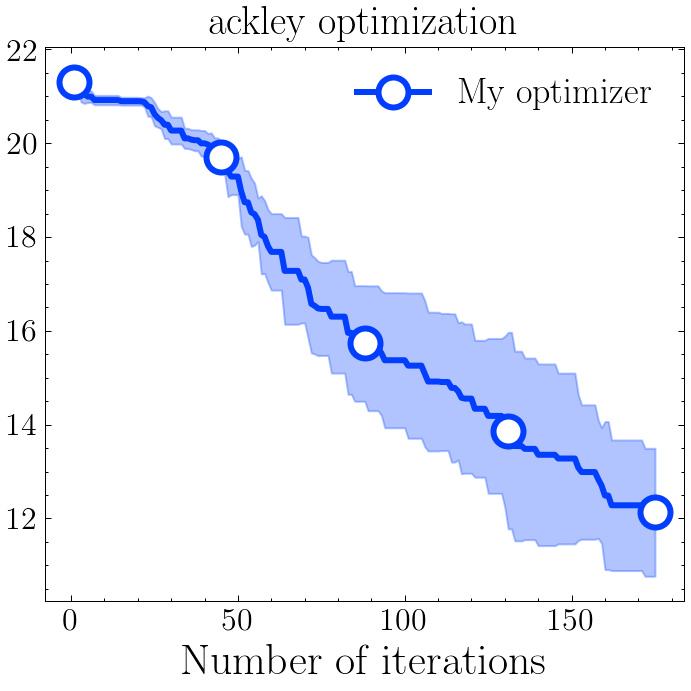

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_task_regrets(ax=ax, data_y=data_y, data_x=np.arange(1, 1 + budget_eval))

ax.set_title(f"{task_id} optimization", fontsize=20)

ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("Number of iterations", fontsize=22)
plt.tight_layout()
plt.show()

## Load results of a several optimizers on a single task

Previous code can be adapted to concatenate the results table of different optimizers. For instance to get results of the same BO algorithm but with a different acquisition function optimizer.

In [9]:
acq_opt_ids = ["ga", "ls", "is"]

all_res = None

for acq_opt_id in acq_opt_ids:
    opt_short_name = get_bo_short_opt_id(model_id=model_id, acq_opt_id=acq_opt_id, acq_func_id=acq_func_id, tr_id=tr_id)
    
    results = get_opt_results(task_id=task_id, opt_short_name=opt_short_name, seeds=seeds, **task_kwargs)
    results = results[results["Eval Num"] <= budget_eval]
    
    if all_res is None:
        all_res = pd.DataFrame(columns=results.columns)
    all_res = pd.concat([all_res, results], ignore_index=True)

results.head()

,Task,Optimizer,Model,Acq opt,Acq func,TR,Seed,Eval Num,f(x),f(x*),Elapsed Time
0,Ackley Function,GP (TO) - Tr-based IS acq optim,GP (TO),IS,EI,basic,42,1,21.421776,21.421776,0.015551
1,Ackley Function,GP (TO) - Tr-based IS acq optim,GP (TO),IS,EI,basic,42,2,21.478069,21.421776,0.030391
2,Ackley Function,GP (TO) - Tr-based IS acq optim,GP (TO),IS,EI,basic,42,3,21.674237,21.421776,0.045066
3,Ackley Function,GP (TO) - Tr-based IS acq optim,GP (TO),IS,EI,basic,42,4,21.358645,21.358645,0.059984
4,Ackley Function,GP (TO) - Tr-based IS acq optim,GP (TO),IS,EI,basic,42,5,21.132280,21.132280,0.074871


##### Build `data_y`
Get data_y by grouping by acquisition optimizer "Acq opt".

In [10]:
data_y = {}

for acq_opt, acq_opt_group in all_res.groupby("Acq opt"):
    data_y[f"Acq Opt: {acq_opt}"] = np.stack([g["f(x*)"].values for s, g in acq_opt_group.groupby("Seed")])

Visualize regrets on the same graph using `plot_task_regrets`.

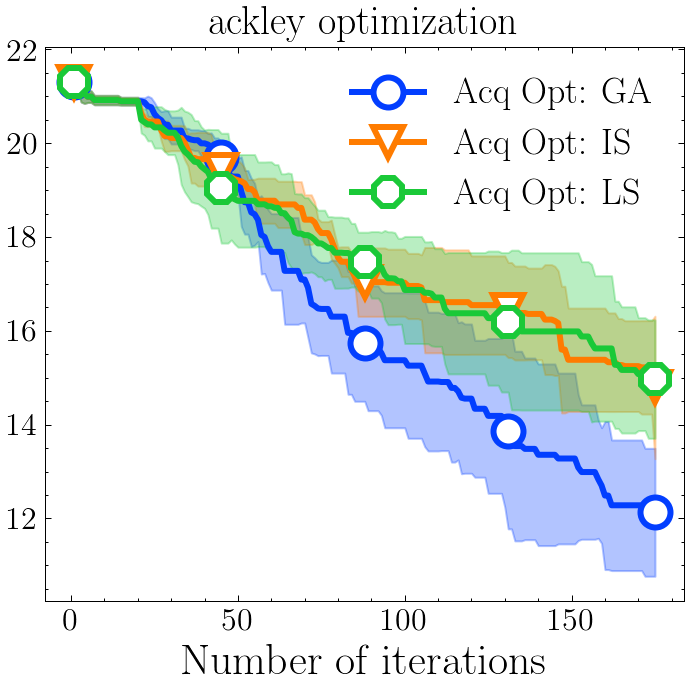

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_task_regrets(ax=ax, data_y=data_y, data_x=np.arange(1, 1 + budget_eval))

ax.legend(fontsize=18)
ax.set_title(f"{task_id} optimization", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("Number of iterations", fontsize=22)
plt.tight_layout()
plt.show()

Visualize regrets on the same graph using `plot_curves_with_ranked_legends`.

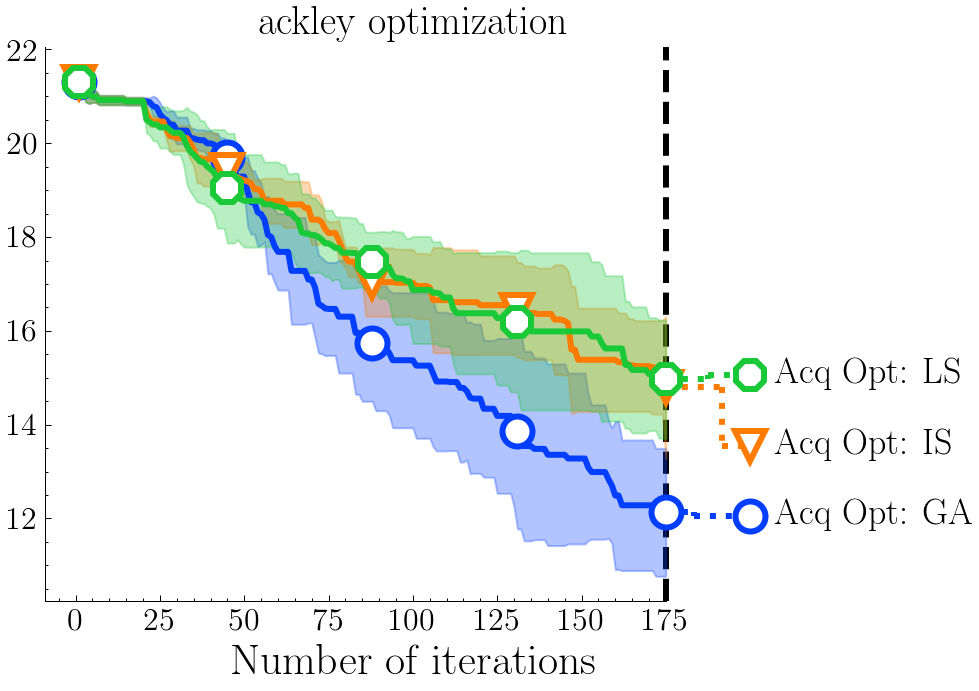

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

plot_curves_with_ranked_legends(ax=ax, data_y=data_y, data_x=np.arange(1, 1 + budget_eval))

ax.set_title(f"{task_id} optimization", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("Number of iterations", fontsize=22)
plt.tight_layout()
plt.show()

## Include results from the MCBO baselines

It is possible to get the results from the dataset provided in [all_res_comb,csv](../paper_results/data_mcbo/all_res_comb.csv) or [all_res_mix.csv](../paper_results/data_mcbo/all_res_mix.csv) (accessible by unzipping [data.zip](../paper_results/data.zip)). To do so we need to:
- load the relevant table (mixed or combinatorial)
- filter the table to keep the entries with desired Optimizer, Task and Seed and evaluation budget

In the running example we have a combinatorial task, so we load `all_res_comb.csv`.

In [13]:
lib_data = pd.read_csv("../paper_results/data_mcbo/all_res_comb.csv", index_col=0)

Select the baselines' results to keep.

In [15]:
# Select MCBO optimizers
selected_optimizers = ["Random Search", "GP (HED-mat52) - Tr-based GA acq optim", "GP (Diffusion) - Tr-based GA acq optim"]

# filter optimizers
lib_data = lib_data[lib_data.Optimizer.isin(selected_optimizers)]

# filter seeds
lib_data = lib_data[lib_data.Seed.isin(seeds)]

# filter task
lib_data = lib_data[lib_data.Task == 'Ackley Function']

# Filter number of evaluations
lib_data = lib_data[lib_data["Eval Num"] <= budget_eval]

Concatenate with custom results

In [16]:
all_res = pd.concat([lib_data, all_res], ignore_index=True)

Visualize evolution of regret.

In [25]:
data_y = {}

for opt, opt_group in all_res.groupby("Optimizer"):
    if opt in selected_optimizers:
        k = f" (Baseline) {opt}"
    else:
        k = f" (Ours) {opt}"
    data_y[k] = np.stack([g["f(x*)"].values for s, g in opt_group.groupby("Seed")])

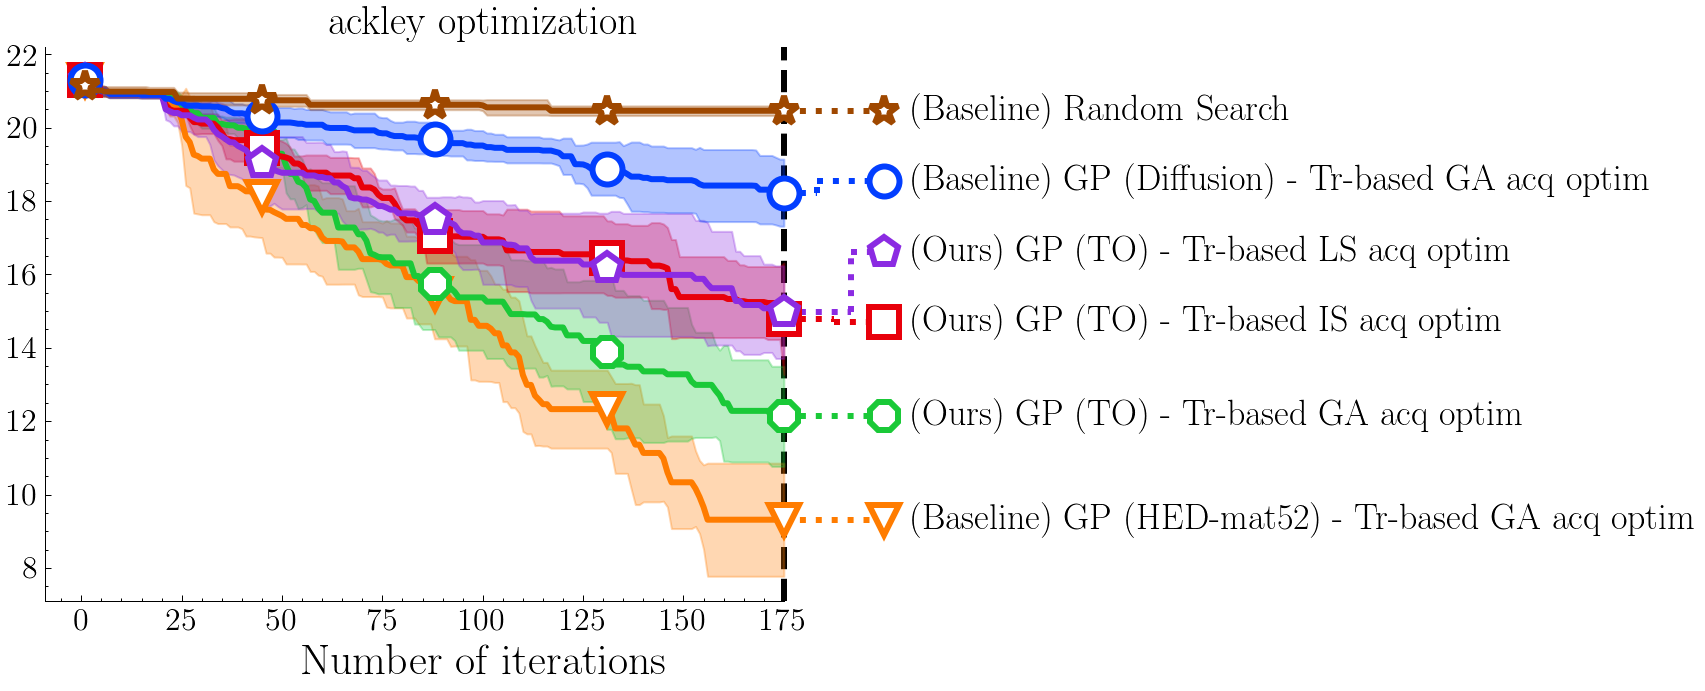

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

plot_curves_with_ranked_legends(ax=ax, data_y=data_y, data_x=np.arange(1, 1 + budget_eval))

ax.set_title(f"{task_id} optimization", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("Number of iterations", fontsize=22)
plt.tight_layout()
plt.show()